In [1]:
from abc import ABC, abstractmethod
import json, os, time
import requests
import random
from datetime import datetime, timezone, timedelta
from pathlib import Path

DATA_START = datetime(2026, 2, 5)
DATA_END = datetime(2026, 2, 11)
DUMMY_PATH = 'dummy.json'
REAL_URL = "https://dummyjson.com/products"
KEY_FILE = 'key.json'

In [2]:
def random_time_window(start, end, window_days: int = 2):
    """
    Generate a random time window between of fixed length (window_days) between 'start' and 'end'.
    
    Parameters
    ----------
    start : The start of the overall time range.
    end : The end of the overall time range.
    window_days : The window of time the start and end range is.

    """
    total_seconds = int((end - start).total_seconds())
    window_seconds = window_days * 86400 # convert days to seconds
    
    if total_seconds < window_seconds:
        raise ValueError(f"Time range must be at least {window_days} days long.")

    # pick random start point
    rand_start_seconds = random.randint(0, total_seconds - window_seconds)
    rand_start = start + timedelta(seconds=rand_start_seconds)
    rand_end = rand_start + timedelta(days=window_days)

    return (
        rand_start.astimezone(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
        rand_end.astimezone(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
    )

def random_comment_window(tweet_created_at, window_days: int = 2):
    """
    Create a random comment window starting after the tweet timestamp.
    """
    tweet_time = datetime.fromisoformat(tweet_created_at.replace("Z", "+00:00"))
    now = datetime.now(timezone.utc) - timedelta(seconds=15) # offsetting the time for acceptable api timing

    # max time you’re allowed to search comments
    max_end = min(tweet_time + timedelta(days=window_days), now)

    if max_end <= tweet_time:
        raise ValueError("Tweet is in the future or no valid comment window.")

    # pick a random start
    delta_seconds = int((max_end - tweet_time).total_seconds() - window_days * 86400)
    delta_seconds = max(delta_seconds, 0)
    
    rand_start_seconds = random.randint(0, delta_seconds) if delta_seconds > 0 else 0
    rand_start = tweet_time + timedelta(seconds=rand_start_seconds)

    seven_days_ago = datetime.now(timezone.utc) - timedelta(days=7)
    rand_start = max(rand_start, seven_days_ago)

    rand_end = min(rand_start + timedelta(days = window_days), max_end)
    rand_end = min(rand_end, datetime.now(timezone.utc) - timedelta(seconds=15))

    return (
        rand_start.astimezone(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
        rand_end.astimezone(timezone.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
    )
    
def save_json(data: dict, folder: str, filename: str):
    """
    Function to save dictionaries as jsons
    """
    os.makedirs(folder, exist_ok=True)
    path = os.path.join(folder, filename)
    with open(path, "w") as f:
        json.dump(data, f, indent=2)
    print(f"Saved → {path}")

In [3]:
# Unfinished Dummy API code

class BaseAPIClient(ABC):
    '''
    We only use this class to define a structure
    and then inherit it. Never use this class directly.
    '''

    @abstractmethod # allows you to define a function with no purpose
    def fetch_data(self) -> dict:
        pass # doesnt do anything
        
class DummyAPIClient(BaseAPIClient):
    '''
    Since this inherist the BaseAPIClient it must
    implement all of its abstract methods
    '''
    def __init__(self):
        print('running in dummy mode')
        return

    def fetch_data(self) -> dict:
        '''
        Load and return the local dummy data
        '''
        with open(DUMMY_PATH, 'r') as f:
            data = json.load(f)
        return data

# START of script

class RealAPIClient(BaseAPIClient):
    '''
    Since this inherist the BaseAPIClient it must
    implement all of its abstract methods
    '''
    def __init__(self, key, bearer):
        self.key = key
        self.bearer = bearer
        return
        
    def fetch_data(self) -> dict:
        """Placeholder to satisfy abstract method requirement."""
        return {}

    def fetch_posts(self,
                    politician_handle: str,
                    randomize_time=True,
                    target_count=10
                   ):
        politician_folder = f"data/posts/{politician_handle}"
        os.makedirs(politician_folder, exist_ok=True)

        posts_path = f"{politician_folder}/{politician_handle}_posts.json"

        existing_posts = []
        collected_post_ids = set()

        # Load posts into exisitng_posts if they exist
        if os.path.exists(posts_path):
            with open(posts_path, "r") as f:
                existing_posts = json.load(f).get("data", [])
                collected_post_ids = {tweet["id"] for tweet in existing_posts}

        # if we have enough posts, STOP
        if len(existing_posts) >= target_count:
            print(f"Already have {len(existing_posts)} posts for {politician_handle}")
            return {"data": existing_posts[:target_count]}, [p["id"] for p in existing_posts[:target_count]]

        collected_posts = existing_posts[:]

        url = "https://api.twitter.com/2/tweets/search/recent"
        headers = {"Authorization": f"Bearer {self.bearer}"}
        
        attempts = 0
        while len(collected_posts) < target_count and attempts <5: # ensures that we only collect 10 posts in each folder
            attempts += 1
            added_this_round = 0 # number of posts added to the folder
            # Step 1: Set or randomize timeframe
            if randomize_time:
                start, end = random_time_window(DATA_START, DATA_END)
            else:
                # manually set date window here
                start = "2025-12-16T19:00:00Z"
                end   = "2025-12-16T21:00:00Z"

            print(f"Fetching tweets for {politician_handle} between {start} and {end}")

            params = {
                "query": f"from:{politician_handle} -is:retweet", # no retweets!
                "start_time": start,
                "end_time": end,
                "max_results": 10,
                "tweet.fields": "id,text,created_at"
            }
    
            # Get response
            response = requests.get(url, headers=headers, params=params)

            if response.status_code == 200:
                print("SUCCESS")
                data = response.json().get("data", [])
                for tweet in data:
                    pid = tweet["id"]
                    if pid not in collected_post_ids:
                        #print(f"Skipping post {pid} — already saved")
                        collected_posts.append(tweet)
                        collected_post_ids.add(pid)
                        added_this_round += 1
                    # only collect 10 posts in the foslder
                    if len(collected_posts) >= target_count:
                        break
                if added_this_round == 0:
                    print("No new posts found - stopping early")
                    continue
                        
            elif response.status_code == 429:
                reset = response.headers.get("x-rate-limit-reset")
                wait = int(reset) - int(time.time()) if reset else 60
                print(f"→ RATE LIMIT HIT. Sleeping {wait} seconds…")
                time.sleep(wait)
            else:
                print("Error:", response.text)
                response.raise_for_status()

        # SAVE FINAL POSTS
        if collected_posts:
            save_json(
                {"data": collected_posts[:target_count]},
                folder=politician_folder,
                filename=f"{politician_handle}_posts.json"
            )
        return {"data": collected_posts[:target_count]}, [p["id"] for p in collected_posts[:target_count]]

    def fetch_comments(self,
                       politician_handle: str,
                       post_id: str,
                       tweet_created_at: str,
                       target_count=10,
                       randomize_time: bool = True
                      ):
        post_folder = f"data/posts/{politician_handle}/{post_id}"
        os.makedirs(post_folder, exist_ok=True)

        comments_path = os.path.join(post_folder, "comments.json")
        
        existing_comments = []
        existing_comment_ids = set()
    
        # LOAD EXISTING COMMENTS
        if os.path.exists(comments_path):
            with open(comments_path, "r") as f:
                existing_comments = json.load(f).get("data", [])
                existing_comment_ids = {c["id"] for c in existing_comments}
        else:
            existing_comments = []
    
        if len(existing_comments) >= target_count:
            print(f"Already have {len(existing_comments)} comments for {post_id}")
            return existing_comments[:target_count]
    
        collected_comments = existing_comments[:]

        url = "https://api.twitter.com/2/tweets/search/recent"
        headers = {"Authorization": f"Bearer {self.bearer}"}

        attempts = 0
        while len(collected_comments) < target_count and attempts < 10:
            attempts += 1
            added_this_round = 0
            
            # Define Timeframe
            start, end = random_comment_window(tweet_created_at, window_days=2)
            print(f"Fetching comments for {post_id} between {start} and {end}")
            
            params = {"query": f"conversation_id:{post_id}",
                      "start_time": start,
                      "end_time": end,
                      "max_results": 10,
                     "tweet.fields": "id,text,created_at"}
    
            response = requests.get(url, headers=headers, params=params)
            
            if response.status_code == 200:
                print("SUCCESS")
                data = response.json().get("data", [])

                for tweet in data:
                    cid = tweet['id']
                    if cid not in existing_comment_ids:
                        collected_comments.append(tweet)
                        existing_comment_ids.add(cid)
                        added_this_round += 1

                    if len(collected_comments) >= target_count:
                        break
                if added_this_round == 0:
                    print("No new comments found - stopping early")
                    break
                
            elif response.status_code == 429:
                reset = response.headers.get("x-rate-limit-reset")
                wait = int(reset) - int(time.time()) if reset else 60
                print(f"→ RATE LIMIT HIT. Sleeping {wait} seconds…")
                time.sleep(wait)
            else: #other Errors
                print("→ ERROR:", response.text)
                response.raise_for_status()

        save_json({"data": collected_comments[:target_count]},
                  folder=post_folder,
                  filename="comments.json")

        return collected_comments[:target_count]

class ToxicityApp:
    def __init__(self):
        if self.load_key():
            self.api = RealAPIClient(self.key, self.bearer)
        else:
            self.api = DummyAPIClient()

    def load_key(self):
        try:
            with open("key.json") as f:
                data = json.load(f)
                self.key = data["X_API_KEY"]
                self.bearer = data["bearer_token"]
            return True
        except:
            print("Could not load key.")
            return False

    def collect_politician_comments(self, 
                                    handles: list[str], 
                                    randomize_time: bool = True
                                   ):
        """
        Handes a list of twitter handles, returns json of posts and comments
        """
        results = {}

        for handle in handles:
            print(f"Collecting posts for {handle}")
            
            posts_json, post_ids = self.api.fetch_posts(handle)
            tweets = posts_json.get("data", [])

            if not post_ids:
                print(f"No posts found for {handle}.")
                results[handle] = {"posts": posts_json, "comments": {}}
                continue
                
            comments_for_this_handle = {}

            # Iterate posts
            for tweet in tweets:
                post_id = tweet["id"]
                created_at = tweet["created_at"]

                comment_data = self.api.fetch_comments(
                    politician_handle=handle,
                    post_id=post_id,
                    tweet_created_at = created_at,
                    target_count=10,
                    randomize_time=randomize_time)
                comments_for_this_handle[post_id] = comment_data
        
            # Store inside the results dictionary
            results[handle] = {
                "posts" : posts_json,
                "comments": comments_for_this_handle
            }

        return results

In [ ]:
app = ToxicityApp()

results = app.collect_politician_comments(
    ["SenTuberville",
     "SenKatieBritt",
     "lisamurkowski",
     "SenDanSullivan",
     "SenRubenGallego",
     "SenMarkKelly",
     "JohnBoozman",
     "SenTomCotton",
     "AlexPadilla4CA",
     "AdamSchiff",
     "MichaelBennet",
     "SenatorHick", 
     "SenBlumenthal", 
     "ChrisMurphyCT", 
     "SenLBR", 
     "ChrisCoons", 
     "SenAshleyMoody", 
     "SenRickScott",
     "SenOssoff", 
     "SenatorWarnock", 
     "SenBrianSchatz",
     "maziehirono", 
     "MikeCrapo", 
     "SenatorRisch", 
     "SenatorDurbin",
     "SenDuckworth", 
     "SenToddYoung", 
     "SenatorBanks", 
     "ChuckGrassley", 
     "SenJoniErnst", 
     "JerryMoran",
     "RogerMarshallMD", 
     "McConnellPress", 
     "RandPaul", 
     "BillCassidy", 
     "SenJohnKennedy", 
     "SenatorCollins",
     "SenAngusKing", 
     "Sen_Alsobrooks", 
     "ChrisVanHollen", 
     "SenWarren", 
     "SenMarkey",
     "SenatorSlotkin",
     "SenGaryPeters", 
     "amyklobuchar", 
     "SenTinaSmith",
     "SenatorWicker",
     "SenHydeSmith", 
     "SenHawleyPress",
     "SenEricSchmitt", 
     "TimSheehyMT", 
     "SteveDaines", 
     "SenatorFischer", 
     "SenatorRicketts" ,
     "SenCortezMasto",
     "SenJackyRosen", 
     "SenatorShaheen", 
     "SenatorHassan", 
     "SenBooker", 
     "AndyKimNJ", 
     "MartinHeinrich",
     "SenatorLujan", 
     "SenSchumer", 
     "gillibrandny", 
     "SenThomTillis", 
     "SenTedBuddNC" , 
     "SenJohnHoeven",
     "SenKevinCramer", 
     "berniemoreno", 
     "SenJonHusted", 
     "SenatorLankford", 
     "SenMullin" , 
     "RonWyden",
     "SenJeffMerkley", 
     "DaveMcCormickPA", 
     "SenFettermanPA", 
     "SenJackReed", 
     "SenWhitehouse", 
     "LindseyGrahamSC", 
     "SenatorTimScott", 
     "johnthune",
     "SenatorRounds", 
     "MarshaBlackburn",
     "SenatorHagerty", 
     "JohnCornyn", 
     "SenTedCruz", 
     "SenJohnCurtis", 
     "SenMikeLee", 
     "SenSanders", 
     "WelchForVT",
     "MarkWarner", 
     "timkaine", 
     "PattyMurray", 
     "SenatorCantwell", 
     "JimJustice_WV", 
     "SenCapito", 
     "SenRonJohnson",
     "SenatorBaldwin", 
     "SenJohnBarrasso", 
     "SenLummis"
    ],
    randomize_time=True
)

Already have 10 posts for SenTuberville
Already have 10 comments for 2017728095743258826
Already have 10 comments for 2017694628565135366
Already have 10 comments for 2017652854744297983
Already have 10 comments for 2017386285246169465
Already have 10 comments for 2017317137682206839
Already have 10 comments for 2017316916092662166
Already have 10 comments for 2017279766496190651
Already have 10 comments for 2017232811292262430
Already have 10 comments for 2016987700696428746
Already have 10 comments for 2016956008489275700
Already have 10 posts for SenKatieBritt
Already have 10 comments for 2017015700963930351
Already have 10 comments for 2016923809404633530
Already have 10 comments for 2016647154593329514
Already have 10 comments for 2016596831652712774
Already have 10 comments for 2016556770018119692
Already have 10 comments for 2016289208462111120
Already have 10 comments for 2017385652195659929
Already have 10 comments for 2017267599441117469
Already have 10 comments for 201726076

['SenatorHick',
 'SenBlumenthal',
 'ChrisMurphyCT',
 'SenLBR',
 'ChrisCoons',
 'SenAshleyMoody',
 'SenRickScott',
 'SenOssoff',
 'SenatorWarnock',
 'SenBrianSchatz',
 'maziehirono',
 'MikeCrapo',
 'SenatorRisch',
 'SenatorDurbin',
 'SenDuckworth',
 'SenToddYoung',
 'SenatorBanks',
 'ChuckGrassley',
 'SenJoniErnst',
 'JerryMoran',
 'RogerMarshallMD',
 'McConnellPress',
 'RandPaul',
 'BillCassidy',
 'SenJohnKennedy',
 'SenatorCollins',
 'SenAngusKing',
 'Sen_Alsobrooks',
 'ChrisVanHollen',
 'SenWarren',
 'SenMarkey',
 'SenatorSlotkin',
 'SenGaryPeters',
 'amyklobuchar',
 'SenTinaSmith',
 'SenatorWicker',
 'SenHydeSmith',
 'SenHawleyPress',
 'SenEricSchmitt',
 'TimSheehyMT',
 'SteveDaines',
 'SenatorFischer',
 'SenatorRicketts',
 'SenCortezMasto',
 'SenJackyRosen',
 'SenatorShaheen',
 'SenatorHassan',
 'SenBooker',
 'AndyKimNJ',
 'MartinHeinrich',
 'SenatorLujan',
 'SenSchumer',
 'gillibrandny',
 'SenThomTillis',
 'SenTedBuddNC',
 'SenJohnHoeven',
 'SenKevinCramer',
 'berniemoreno',
 'Sen

In [5]:
handles = ["SenTuberville",
     "SenKatieBritt",
     "lisamurkowski",
     "SenDanSullivan",
     "SenRubenGallego",
     "SenMarkKelly",
     "JohnBoozman",
     "SenTomCotton",
     "AlexPadilla4CA",
     "AdamSchiff",
     "MichaelBennet",
     "SenatorHick", 
     "SenBlumenthal", 
     "ChrisMurphyCT", 
     "SenLBR", 
     "ChrisCoons", 
     "SenAshleyMoody", 
     "SenRickScott",
     "SenOssoff", 
     "SenatorWarnock", 
     "SenBrianSchatz",
     "maziehirono", 
     "MikeCrapo", 
     "SenatorRisch", 
     "SenatorDurbin",
     "SenDuckworth", 
     "SenToddYoung", 
     "SenatorBanks", 
     "ChuckGrassley", 
     "SenJoniErnst", 
     "JerryMoran",
     "RogerMarshallMD", 
     "McConnellPress", 
     "RandPaul", 
     "BillCassidy", 
     "SenJohnKennedy", 
     "SenatorCollins",
     "SenAngusKing", 
     "Sen_Alsobrooks", 
     "ChrisVanHollen", 
     "SenWarren", 
     "SenMarkey",
     "SenatorSlotkin",
     "SenGaryPeters", 
     "amyklobuchar", 
     "SenTinaSmith",
     "SenatorWicker",
     "SenHydeSmith", 
     "SenHawleyPress",
     "SenEricSchmitt", 
     "TimSheehyMT", 
     "SteveDaines", 
     "SenatorFischer", 
     "SenatorRicketts" ,
     "SenCortezMasto",
     "SenJackyRosen", 
     "SenatorShaheen", 
     "SenatorHassan", 
     "SenBooker", 
     "AndyKimNJ", 
     "MartinHeinrich",
     "SenatorLujan", 
     "SenSchumer", 
     "gillibrandny", 
     "SenThomTillis", 
     "SenTedBuddNC" , 
     "SenJohnHoeven",
     "SenKevinCramer", 
     "berniemoreno", 
     "SenJonHusted", 
     "SenatorLankford", 
     "SenMullin" , 
     "RonWyden",
     "SenJeffMerkley", 
     "DaveMcCormickPA", 
     "SenFettermanPA", 
     "SenJackReed", 
     "SenWhitehouse", 
     "LindseyGrahamSC", 
     "SenatorTimScott", 
     "johnthune",
     "SenatorRounds", 
     "MarshaBlackburn",
     'SenatorHagerty',
     'JohnCornyn',
     'SenTedCruz',
     'SenJohnCurtis',
     'SenMikeLee',
     'SenSanders',
     'WelchForVT',
     'MarkWarner',
     'timkaine',
     'PattyMurray',
     'SenatorCantwell',
     'JimJustice_WV',
     'SenCapito',
     'SenRonJohnson',
      'SenatorBaldwin',
      'SenJohnBarrasso',
     'SenLummis']

In [6]:
len(handles)

100

In [7]:
import os
import json
import pandas as pd
from typing import List

def load_saved_posts(handles: List[str], base_path=r"C:\Users\User\OneDrive - William & Mary\Desktop\Project\data\posts") -> pd.DataFrame:
    posts_frames = []

    for handle in handles:
        path = f"{base_path}/{handle}/{handle}_posts.json"

        if not os.path.exists(path):
            print(f"No saved posts for {handle}")
            continue
        
        with open(path, "r") as f:
            posts = json.load(f).get("data", [])

        if not posts:
            print(f"Empty file for {handle}")
            continue

        df = pd.DataFrame(posts)
        df["handle"] = handle
        posts_frames.append(df)
    
    if not posts_frames:
        return pd.DataFrame()
    
    posts_df = pd.concat(posts_frames, ignore_index = True)

    # remove dupes
    if "id" in posts_df.columns:
        posts_df = posts_df.drop_duplicates(subset=["id"]).reset_index(drop=True)
    
    if "created_at" in posts_df.columns:
        posts_df["created_at"] = pd.to_datetime(posts_df["created_at"], utc=True, errors="coerce")

    return posts_df

In [8]:
posts_df = load_saved_posts(handles)

posts_df.tail()

No saved posts for McConnellPress


,created_at,id,edit_history_tweet_ids,text,handle
742,2026-02-07 19:37:00+00:00,2020220267243380881,[2020220267243380881],Always fabulous to see my friends from Wyoming...,SenLummis
743,2026-02-06 22:57:00+00:00,2019908211076395391,[2019908211076395391],Kevin Warsh is highly qualified and will bring...,SenLummis
744,2026-02-06 19:29:35+00:00,2019856012178784419,[2019856012178784419],This is the most pro-digital asset administrat...,SenLummis
745,2026-02-06 01:01:00+00:00,2019577029050401212,[2019577029050401212],Digital assets are the future of financial ser...,SenLummis
746,2026-02-08 17:31:57+00:00,2020551186277957881,[2020551186277957881],What an incredible achievement! Congratulation...,SenLummis


In [13]:
# Define the file path and name for the JSON file
file_path = r"C:\Users\User\OneDrive - William & Mary\Desktop\Project\posts.json"

# Convert the DataFrame to a JSON string
# 'orient' parameter determines the JSON file structure (e.g., 'records', 'columns', 'index')
json_string = posts_df.to_json(orient='records', indent=4) 

# Write the JSON string to a file
try:
    with open(file_path, 'w') as f:
        f.write(json_string)
    print(f"Successfully saved DataFrame to {file_path}")
except IOError as e:
    print(f"Error saving file: {e}")

Successfully saved DataFrame to C:\Users\User\OneDrive - William & Mary\Desktop\Project\posts.json


In [38]:
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv("US Federal Elected Officials - Factors_updated.csv")
df.head()

,Name,Handle,2nd handle,Handle run by self? (yes/no),M/F,State,Party,Age,Year of birth,Education,Marital Status,Term #,Race (black/white/latinx/PoC),President's Office / Congress / Senate,Campaign Finance / Income,Number of followers on X,Updated (yes/no)
0,Name,Handle,2nd handle,Handle run by self? (yes/no),M/F,State,Party,Age,Year of birth,Education,Marital Status,Term #,Race (black/white/latinx/PoC),President's Office / Congress / Senate,Campaign Finance / Income,Number of followers on X,Updated (yes/no)
1,Tommy Tuberville,@SenTuberville,@TTuberville,NaN,M,Alabama,Republican,70,1954,BS in Physical Education,married,1,white,S,"$11,684,053",NaN,yes
2,Katie Britt,@SenKatieBritt,@KatieBrittforAL,NaN,F,Alabama,Republican,42,1982,Juris Doctor and BS Political Science,married,1,white,S,"$15,313,397",NaN,yes
3,Lisa Murkowski,@lisamurkowski,@LisaForSenate,NaN,F,Alaska,Republican,67,1957,Juris Doctor and BA Economics,married,4,white,S,"$10,964,334",NaN,yes
4,Dan Sullivan,@SenDanSullivan,@DanSullivan_AK,NaN,M,Alaska,Republican,60,1964,"MS Foreign Service and Juris Doctor, BA Economics",married,2,white,S,"$11,438,621",NaN,yes


In [22]:
df = df.drop(df.index[0])
df

,Name,Handle,2nd handle,Handle run by self? (yes/no),M/F,State,Party,Age,Year of birth,Education,Marital Status,Term #,Race (black/white/latinx/PoC),President's Office / Congress / Senate,Campaign Finance / Income,Number of followers on X,Updated (yes/no)
1,Tommy Tuberville,@SenTuberville,@TTuberville,NaN,M,Alabama,Republican,70,1954,BS in Physical Education,married,1,white,S,"$11,684,053",NaN,yes
2,Katie Britt,@SenKatieBritt,@KatieBrittforAL,NaN,F,Alabama,Republican,42,1982,Juris Doctor and BS Political Science,married,1,white,S,"$15,313,397",NaN,yes
3,Lisa Murkowski,@lisamurkowski,@LisaForSenate,NaN,F,Alaska,Republican,67,1957,Juris Doctor and BA Economics,married,4,white,S,"$10,964,334",NaN,yes
4,Dan Sullivan,@SenDanSullivan,@DanSullivan_AK,NaN,M,Alaska,Republican,60,1964,"MS Foreign Service and Juris Doctor, BA Economics",married,2,white,S,"$11,438,621",NaN,yes
5,Ruben Gallego,@SenRubenGallego,NaN,NaN,M,Arizona,Democratic,NaN,1979,BA in Government,married,1,white,S,"$63,777,612",NaN,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Shelley Moore Capito,@SenCapito,NaN,NaN,F,West Virginia,Republican,71,1953,"MEd (University of Virginia), BA in Zoology (D...",married,3,white,S,"$6,809,822",NaN,yes
97,Ron Johnson,@SenRonJohnson,NaN,NaN,M,Wisconsin,Republican,69,1955,BA in Business and Accounting (University of M...,married,3,white,S,"$40,097,439",NaN,yes
98,Tammy Baldwin,@SenatorBaldwin,NaN,NaN,F,Wisconsin,Democratic,62,1962,"JD (University of Wisconsin Law School), BA (S...",unmarried,3,white,S,"$58,515,036",NaN,yes
99,John Barrasso,@SenJohnBarrasso,NaN,NaN,M,Wyoming,Republican,72,1952,"MD, BS in Biology (Georgetown University)",widowed,3,white,S,"$10,586,702",NaN,yes


In [ ]:
## Adding Age for Ruben Gallego
df["Age"][5] = 45

[Text(0, 1, '73'), Text(0, 1, '27')]

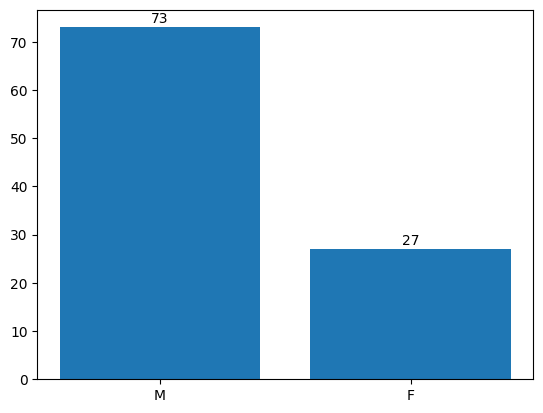

In [58]:
## Gender Stats

fig, ax = plt.subplots()

bars = plt.bar(df["M/F"].unique(), df["M/F"].value_counts())
ax.bar_label(bars, padding=1)


[Text(0, 1, '52'), Text(0, 1, '45'), Text(0, 1, '3')]

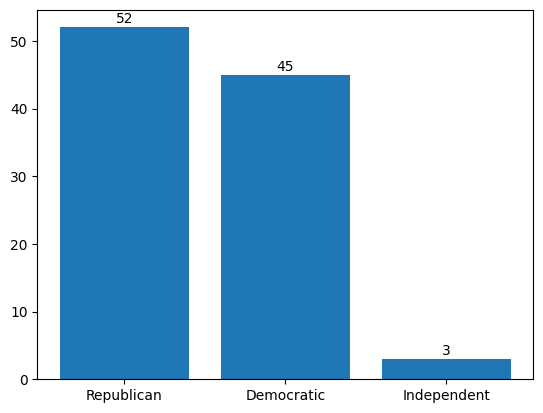

In [ ]:
# Party Stats
fig, ax = plt.subplots()

bars = plt.bar(df["Party"].unique(), df["Party"].value_counts())
ax.bar_label(bars, padding=1)

In [90]:
# Median Age
df["Age"].median()

np.float64(66.0)

In [91]:
df["Marital Status"].value_counts()

Marital Status
married      87
unmarried     5
widowed       4
divorced      3
seperated     1
Name: count, dtype: int64

[Text(0, 1, '87'),
 Text(0, 1, '5'),
 Text(0, 1, '4'),
 Text(0, 1, '3'),
 Text(0, 1, '1')]

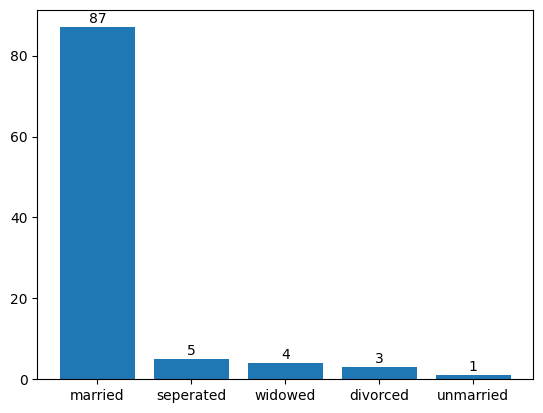

In [ ]:
# Marital Counts
fig, ax = plt.subplots()

bars = plt.bar(df["Marital Status"].unique(), df["Marital Status"].value_counts())
ax.bar_label(bars, padding=1)

[Text(0, 1, '33'),
 Text(0, 1, '26'),
 Text(0, 1, '17'),
 Text(0, 1, '12'),
 Text(0, 1, '8'),
 Text(0, 1, '2'),
 Text(0, 1, '2')]

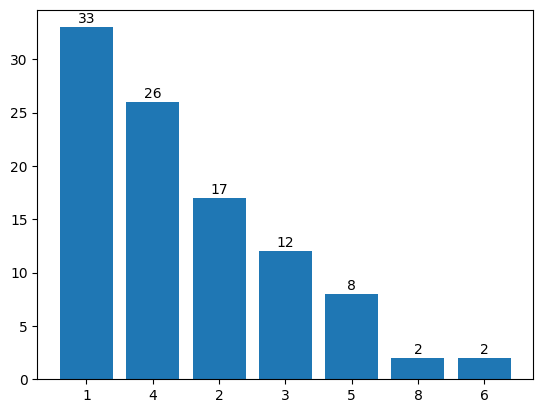

In [ ]:
# Term counts
fig, ax = plt.subplots()

bars = plt.bar(df["Term #"].unique(), df["Term #"].value_counts())
ax.bar_label(bars, padding=1)

[Text(0, 1, '86'),
 Text(0, 1, '5'),
 Text(0, 1, '4'),
 Text(0, 1, '4'),
 Text(0, 1, '1')]

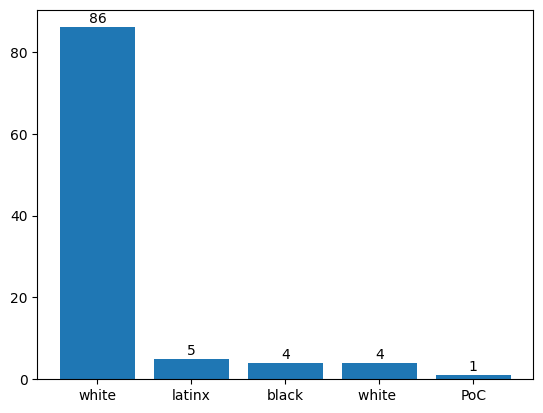

In [100]:
# Race
fig, ax = plt.subplots()

bars = plt.bar(df["Race (black/white/latinx/PoC)"].unique(), df["Race (black/white/latinx/PoC)"].value_counts())
ax.bar_label(bars, padding=1)



In [ ]:
# Removing dollar sign and commas from income column
df['Campaign Finance / Income'] = df['Campaign Finance / Income'].str.replace('$', '', regex=False)
df['Campaign Finance / Income'] = df['Campaign Finance / Income'].str.replace(',', '', regex=False)
df['Campaign Finance / Income'] = df['Campaign Finance / Income'].astype(float)

In [ ]:
# Average Campaign Finance / Income
df["Campaign Finance / Income"].mean()

np.float64(28436082.66)

Post Dataframe Dissection

In [133]:
len(posts_df)

747

In [134]:
posts_df.head()

,created_at,id,edit_history_tweet_ids,text,handle
0,2026-01-31 22:34:00+00:00,2017728095743258826,[2017728095743258826],"Thank you, @POTUS and @SecScottBessent, for he...",SenTuberville
1,2026-01-31 20:21:01+00:00,2017694628565135366,[2017694628565135366],Coach’s Playbook entry #5 : Surround yourself ...,SenTuberville
2,2026-01-31 17:35:01+00:00,2017652854744297983,[2017652854744297983],"Life begins at the moment of conception, and a...",SenTuberville
3,2026-01-30 23:55:46+00:00,2017386285246169465,[2017386285246169465],I voted for today’s appropriations bills to fu...,SenTuberville
4,2026-01-30 19:21:00+00:00,2017317137682206839,[2017317137682206839],ZERO American taxpayer dollars should go to te...,SenTuberville


In [ ]:
# How many posts for each politician do we have?
posts_df["handle"].value_counts()

handle
SenTuberville      10
SenKatieBritt      10
SenDanSullivan     10
SenJohnKennedy     10
SenRubenGallego    10
                   ..
SenHawleyPress      1
MartinHeinrich      1
DaveMcCormickPA     1
johnthune           1
WelchForVT          1
Name: count, Length: 99, dtype: int64

In [142]:
politicians_w_ten = posts_df.groupby("handle").filter(lambda x: len(x) == 10)
len(politicians_w_ten["handle"].unique())

55

In [148]:
post_counts = posts_df.groupby("handle").size()
distribution = post_counts.value_counts().sort_index(ascending=False)
distribution = distribution.reindex(range(10, -1, -1), fill_value=0)

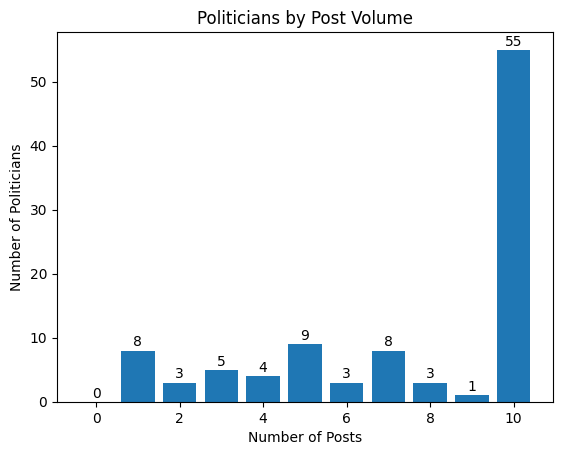

In [151]:
fig, ax = plt.subplots()

bars = plt.bar(distribution.index, distribution.values)
ax.bar_label(bars, padding=1)

plt.xlabel("Number of Posts")
plt.ylabel("Number of Politicians")
plt.title("Politicians by Post Volume")

plt.show()

In [152]:
posts_df.head()

,created_at,id,edit_history_tweet_ids,text,handle
0,2026-01-31 22:34:00+00:00,2017728095743258826,[2017728095743258826],"Thank you, @POTUS and @SecScottBessent, for he...",SenTuberville
1,2026-01-31 20:21:01+00:00,2017694628565135366,[2017694628565135366],Coach’s Playbook entry #5 : Surround yourself ...,SenTuberville
2,2026-01-31 17:35:01+00:00,2017652854744297983,[2017652854744297983],"Life begins at the moment of conception, and a...",SenTuberville
3,2026-01-30 23:55:46+00:00,2017386285246169465,[2017386285246169465],I voted for today’s appropriations bills to fu...,SenTuberville
4,2026-01-30 19:21:00+00:00,2017317137682206839,[2017317137682206839],ZERO American taxpayer dollars should go to te...,SenTuberville


In [155]:
# How many words per post?

word_counts = []

for each_post in posts_df["text"]:
    words = each_post.split()
    word_counts.append(len(words))
posts_df["word_count"] = word_counts


In [164]:
posts_df.head()

,created_at,id,edit_history_tweet_ids,text,handle,word_count
0,2026-01-31 22:34:00+00:00,2017728095743258826,[2017728095743258826],"Thank you, @POTUS and @SecScottBessent, for he...",SenTuberville,14
1,2026-01-31 20:21:01+00:00,2017694628565135366,[2017694628565135366],Coach’s Playbook entry #5 : Surround yourself ...,SenTuberville,34
2,2026-01-31 17:35:01+00:00,2017652854744297983,[2017652854744297983],"Life begins at the moment of conception, and a...",SenTuberville,36
3,2026-01-30 23:55:46+00:00,2017386285246169465,[2017386285246169465],I voted for today’s appropriations bills to fu...,SenTuberville,45
4,2026-01-30 19:21:00+00:00,2017317137682206839,[2017317137682206839],ZERO American taxpayer dollars should go to te...,SenTuberville,36


In [ ]:
# What is the average word count for a tweet across all politicians?
posts_df["word_count"].mean()

np.float64(31.63855421686747)

In [ ]:
# What is the average word count a politician uses in a tweet?
mean_word_count_per_politician = posts_df.groupby('handle')['word_count'].mean()
mean_word_count_per_politician

handle
AdamSchiff        30.500000
AlexPadilla4CA    12.000000
AndyKimNJ         43.200000
BillCassidy       34.300000
ChrisCoons        34.700000
                    ...    
gillibrandny      45.400000
johnthune         45.000000
lisamurkowski     32.333333
maziehirono       37.200000
timkaine          30.142857
Name: word_count, Length: 99, dtype: float64

In [170]:
posts_df[posts_df["handle"] == "AlexPadilla4CA"]

,created_at,id,edit_history_tweet_ids,text,handle,word_count
73,2026-02-04 20:20:52+00:00,2019144144707547598,[2019144144707547598],Now let’s get to work and go win back the Hous...,AlexPadilla4CA,12


In [174]:
df['Handle'] = df['Handle'].str.replace('@', '', regex=False)
df['Handle']

1        SenTuberville
2        SenKatieBritt
3        lisamurkowski
4       SenDanSullivan
5      SenRubenGallego
            ...       
96           SenCapito
97       SenRonJohnson
98      SenatorBaldwin
99     SenJohnBarrasso
100          SenLummis
Name: Handle, Length: 100, dtype: object

In [ ]:
df

,Name,Handle,2nd handle,Handle run by self? (yes/no),M/F,State,Party,Age,Year of birth,Education,Marital Status,Term #,Race (black/white/latinx/PoC),President's Office / Congress / Senate,Campaign Finance / Income,Number of followers on X,Updated (yes/no)
1,Tommy Tuberville,SenTuberville,@TTuberville,NaN,M,Alabama,Republican,70,1954,BS in Physical Education,married,1,white,S,11684053.0,NaN,yes
2,Katie Britt,SenKatieBritt,@KatieBrittforAL,NaN,F,Alabama,Republican,42,1982,Juris Doctor and BS Political Science,married,1,white,S,15313397.0,NaN,yes
3,Lisa Murkowski,lisamurkowski,@LisaForSenate,NaN,F,Alaska,Republican,67,1957,Juris Doctor and BA Economics,married,4,white,S,10964334.0,NaN,yes
4,Dan Sullivan,SenDanSullivan,@DanSullivan_AK,NaN,M,Alaska,Republican,60,1964,"MS Foreign Service and Juris Doctor, BA Economics",married,2,white,S,11438621.0,NaN,yes
5,Ruben Gallego,SenRubenGallego,NaN,NaN,M,Arizona,Democratic,45,1979,BA in Government,married,1,white,S,63777612.0,NaN,yes


In [181]:
posts_df.rename(columns={'handle': 'Handle'}, inplace=True)


In [183]:
merged_df = pd.merge(posts_df, df, on='Handle', how='left')
merged_df

,created_at,id,edit_history_tweet_ids,text,Handle,word_count,Name,2nd handle,Handle run by self? (yes/no),M/F,...,Age,Year of birth,Education,Marital Status,Term #,Race (black/white/latinx/PoC),President's Office / Congress / Senate,Campaign Finance / Income,Number of followers on X,Updated (yes/no)
0,2026-01-31 22:34:00+00:00,2017728095743258826,[2017728095743258826],"Thank you, @POTUS and @SecScottBessent, for he...",SenTuberville,14,Tommy Tuberville,@TTuberville,NaN,M,...,70,1954,BS in Physical Education,married,1,white,S,11684053.0,NaN,yes
1,2026-01-31 20:21:01+00:00,2017694628565135366,[2017694628565135366],Coach’s Playbook entry #5 : Surround yourself ...,SenTuberville,34,Tommy Tuberville,@TTuberville,NaN,M,...,70,1954,BS in Physical Education,married,1,white,S,11684053.0,NaN,yes
2,2026-01-31 17:35:01+00:00,2017652854744297983,[2017652854744297983],"Life begins at the moment of conception, and a...",SenTuberville,36,Tommy Tuberville,@TTuberville,NaN,M,...,70,1954,BS in Physical Education,married,1,white,S,11684053.0,NaN,yes
3,2026-01-30 23:55:46+00:00,2017386285246169465,[2017386285246169465],I voted for today’s appropriations bills to fu...,SenTuberville,45,Tommy Tuberville,@TTuberville,NaN,M,...,70,1954,BS in Physical Education,married,1,white,S,11684053.0,NaN,yes
4,2026-01-30 19:21:00+00:00,2017317137682206839,[2017317137682206839],ZERO American taxpayer dollars should go to te...,SenTuberville,36,Tommy Tuberville,@TTuberville,NaN,M,...,70,1954,BS in Physical Education,married,1,white,S,11684053.0,NaN,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,2026-02-07 19:37:00+00:00,2020220267243380881,[2020220267243380881],Always fabulous to see my friends from Wyoming...,SenLummis,43,Cynthia Lummis,NaN,NaN,F,...,70,1954,"JD, BS in Biology, BS in Animal Science (Unive...",widowed,1,white,S,3581540.0,NaN,yes
743,2026-02-06 22:57:00+00:00,2019908211076395391,[2019908211076395391],Kevin Warsh is highly qualified and will bring...,SenLummis,42,Cynthia Lummis,NaN,NaN,F,...,70,1954,"JD, BS in Biology, BS in Animal Science (Unive...",widowed,1,white,S,3581540.0,NaN,yes
744,2026-02-06 19:29:35+00:00,2019856012178784419,[2019856012178784419],This is the most pro-digital asset administrat...,SenLummis,20,Cynthia Lummis,NaN,NaN,F,...,70,1954,"JD, BS in Biology, BS in Animal Science (Unive...",widowed,1,white,S,3581540.0,NaN,yes
745,2026-02-06 01:01:00+00:00,2019577029050401212,[2019577029050401212],Digital assets are the future of financial ser...,SenLummis,31,Cynthia Lummis,NaN,NaN,F,...,70,1954,"JD, BS in Biology, BS in Animal Science (Unive...",widowed,1,white,S,3581540.0,NaN,yes
